In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib


In [12]:
races        = pd.read_csv("races.csv")
results      = pd.read_csv("results.csv")
drivers      = pd.read_csv("drivers.csv")
constructors = pd.read_csv("constructors.csv")
pit_stops    = pd.read_csv("pit_stops.csv")
weather      = pd.read_csv("F1 Weather(2023-2018) (1).csv")

races = races[races["year"] >= 2018].copy()

df = results.merge(
    races[["raceId","year","round","name"]].rename(columns={"name":"gp_name"}),
    on="raceId", how="inner"
)

df = df.merge(drivers[["driverId","forename","surname"]], on="driverId", how="left")
df = df.merge(constructors[["constructorId","name"]].rename(columns={"name":"team"}),
              on="constructorId", how="left")

weather = weather.rename(columns={"Year":"year","Round Number":"round","Rainfall":"rain"})
weather["is_rain"] = weather["rain"].astype(str).str.lower().isin(["true","yes","1"])
df = df.merge(weather[["year","round","is_rain"]], on=["year","round"], how="left")
df["is_rain"] = df["is_rain"].fillna(False)

if "milliseconds" not in pit_stops.columns and "duration" in pit_stops.columns:
    pit_stops["duration"] = pd.to_numeric(pit_stops["duration"], errors="coerce")
    pit_stops["milliseconds"] = pit_stops["duration"] * 1000

pit_agg = pit_stops.groupby(["raceId","driverId"]).agg(
    n_pitstops=("stop","count"),
    avg_pit_ms=("milliseconds","mean")
).reset_index()

df = df.merge(pit_agg, on=["raceId","driverId"], how="left")
df["n_pitstops"] = df["n_pitstops"].fillna(0).astype(int)
df["avg_pit_ms"] = df["avg_pit_ms"].fillna(df["avg_pit_ms"].median())

df["milliseconds"] = pd.to_numeric(df["milliseconds"], errors="coerce")
df = df.dropna(subset=["milliseconds"]).copy()

df["grid"]          = pd.to_numeric(df["grid"], errors="coerce")
df["positionOrder"] = pd.to_numeric(df["positionOrder"], errors="coerce")
df["places_gained"] = df["grid"] - df["positionOrder"]

df["grid"]          = df["grid"].fillna(df["grid"].median())
df["positionOrder"] = df["positionOrder"].fillna(df["positionOrder"].median())
df["places_gained"] = df["places_gained"].fillna(0)

df.head()

/var/folders/6y/bgq48wy56sl55016m2z598fh0000gn/T/ipykernel_42335/1207322929.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["is_rain"] = df["is_rain"].fillna(False)


Shape final après merges: (205770, 28)


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,year,round,gp_name,forename,surname,team,is_rain,n_pitstops,avg_pit_ms,places_gained
0,23782,989,20,6,5,3,1,1,1,25.0,...,2018,1,Australian Grand Prix,Sebastian,Vettel,Ferrari,False,1,21787.0,2
1,23782,989,20,6,5,3,1,1,1,25.0,...,2018,1,Australian Grand Prix,Sebastian,Vettel,Ferrari,False,1,21787.0,2
2,23782,989,20,6,5,3,1,1,1,25.0,...,2018,1,Australian Grand Prix,Sebastian,Vettel,Ferrari,False,1,21787.0,2
3,23782,989,20,6,5,3,1,1,1,25.0,...,2018,1,Australian Grand Prix,Sebastian,Vettel,Ferrari,False,1,21787.0,2
4,23782,989,20,6,5,3,1,1,1,25.0,...,2018,1,Australian Grand Prix,Sebastian,Vettel,Ferrari,False,1,21787.0,2


In [13]:
target = "milliseconds"

num_cols = ["year","round","grid","n_pitstops","avg_pit_ms"]
cat_cols = ["gp_name","forename","surname","team","is_rain"]

X = df[num_cols + cat_cols].copy()
y = df[target].astype(float)


📊 Nombre total de lignes : 205770
📊 Nombre de colonnes utilisées pour X : 10
📊 Colonnes utilisées : ['year', 'round', 'grid', 'n_pitstops', 'avg_pit_ms', 'gp_name', 'forename', 'surname', 'team', 'is_rain']
🎯 Target : milliseconds


In [14]:
preproc = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline([
    ("prep", preproc),
    ("rf", rf)
])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape

((164616, 10), (41154, 10))

In [16]:
pipe.fit(X_train, y_train)

Modèle entraîné 


In [17]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = pipe.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)   
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)


MAE  ≈ 0.06 s
RMSE ≈ 2.91 s
R²                   :  1.000


In [18]:
joblib.dump(pipe, "model_time_rf.pkl")

Modèle sauvegardé → model_time_rf.pkl


In [19]:
df_ex = pd.DataFrame([{
    "year": 2024,
    "round": 1,
    "gp_name": "Bahrain Grand Prix",
    "forename": "Max",
    "surname": "Verstappen",
    "team": "Red Bull",
    "grid": 2,
    "n_pitstops": 2,
    "avg_pit_ms": 2300.0,
    "is_rain": False
}])

pred_ms = pipe.predict(df_ex)[0]


Temps prédit : 5,183,280 ms (~5,183.3 s)


⏱️ Temps sec P1 : 5181.9 s
🌧️ Temps pluie : 5579.2 s
⬇️ Temps départ P10 : 5192.2 s


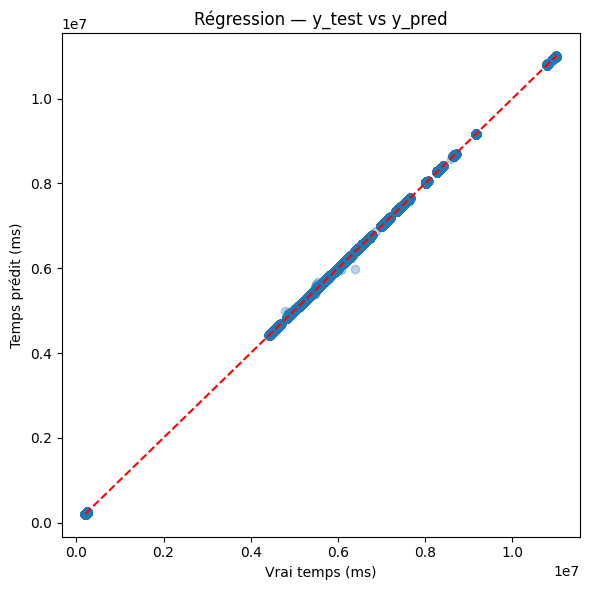

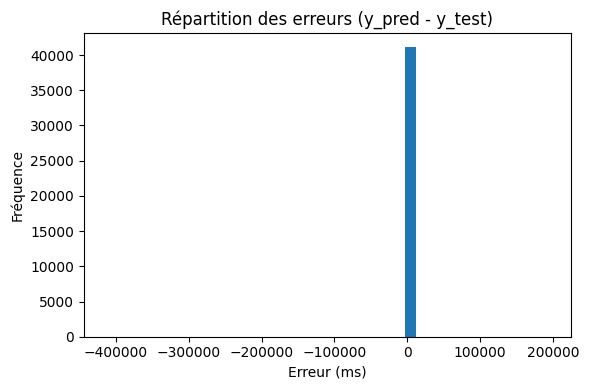

In [20]:
import pandas as pd

df_ex = pd.DataFrame([{
    "year": 2024,
    "round": 1,
    "gp_name": "Bahrain Grand Prix",
    "forename": "Max",
    "surname": "Verstappen",
    "team": "Red Bull",
    "grid": 1,
    "n_pitstops": 2,
    "avg_pit_ms": 2300.0,
    "is_rain": False
}])

pred_base = pipe.predict(df_ex)[0]
df_ex_rain = df_ex.copy(); df_ex_rain["is_rain"] = True
pred_rain = pipe.predict(df_ex_rain)[0]

df_ex_back = df_ex.copy(); df_ex_back["grid"] = 10
pred_back = pipe.predict(df_ex_back)[0]

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Vrai temps (ms)")
plt.ylabel("Temps prédit (ms)")
plt.title("Régression — y_test vs y_pred")
plt.tight_layout()
plt.savefig("eval_reg_scatter.png", dpi=150)
plt.show()
errors = y_pred - y_test

plt.figure(figsize=(6,4))
plt.hist(errors, bins=40)
plt.title("Répartition des erreurs (y_pred - y_test)")
plt.xlabel("Erreur (ms)")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.savefig("eval_reg_errors.png", dpi=150)
plt.show()
